### **Setup:**

**Add pre-installed package path & load packages:**

In [1]:
.libPaths(c(.libPaths(), "/exports/eddie3_apps_local/apps/SL7/R/4.3.0/lib64/R/library"))

In [2]:
#remotes::install_github('MRCIEU/TwoSampleMR')

In [2]:
library("dplyr", warn.conflicts = F)
library("stringr", warn.conflicts = F)
library("data.table", warn.conflicts = F) 
library("vroom", warn.conflicts = F)
library("ggplot2", warn.conflicts = F)
library("TwoSampleMR")
library("readxl")

TwoSampleMR version 0.5.11 
[>] New: Option to use non-European LD reference panels for clumping etc
[>] Some studies temporarily quarantined to verify effect allele
[>] See news(package = 'TwoSampleMR') and https://gwas.mrcieu.ac.uk for further details



You are running an old version of the TwoSampleMR package.
This version:   0.5.11
Latest version: 0.6.14
Please consider updating using remotes::install_github('MRCIEU/TwoSampleMR')



**Change working directory:**

In [3]:
wd = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/"
setwd(wd)
getwd()

[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD"

**Load PWAS results:**

In [5]:
pwas <- fread('proteomics/delirium/output_pwas_models12/del_model1_glm_int_fullset_sumstats.txt') 

**Load druggable genome data:**

In [6]:
dg <- readxl::read_xlsx('resources/druggable_genome_Finan_etal2017/aag1166_Table S1.xlsx', sheet='Data')

**Load MR results:**

In [4]:
## UKB-FG (discovery)
#ukbFG <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukbFG/mr_pQTLs_delirium_1by1_thres0.2_cis_main.csv')
## UKB (discovery)
ukb <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_main.csv')
## AoU (replication)
aou <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/AoU_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_main.csv')
## FG (replication)
fg <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/FG_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_main.csv')
## UKB no-dementia
ukb_nodem <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/nodem/mr_pQTLs_delirium_1by1_thres0.2_cis_main.csv')

**Load single cis-pQTL MR results:**

In [7]:
ukb_wr <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_WR.csv')
fg_wr  <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/FG_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_WR.csv')

**Load MR sensitivity analyses:**

In [9]:
## UKB (discovery)
ukb_pleio <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_pleio.csv')
ukb_het   <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_het.csv')
## FG (replication)
fg_pleio <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/FG_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_pleio.csv')
fg_het   <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/FG_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_het.csv')

### **Merge main results:**

In [10]:
formatMR <- function(mr, type='MRdisc') { 
    mr_IVW <- 
    mr %>% 
    filter(method == 'IVW') %>%
    #select(-c('outcome')) %>% 
    rename_with(., ~ paste0(.x, paste0('.', type)))
    return(mr_IVW)
}

In [11]:
## reformat MR results
# discovery
# ukbFG_IVW <- formatMR(ukbFG, type='MRdisc')
ukb_IVW   <- formatMR(ukb, type='MRdisc')
# replication
fg_IVW  <- formatMR(fg, type='MRrep')
aou_IVW <- formatMR(aou, type='MRrep')
ukb_nodem_IVW <- formatMR(ukb_nodem, type='MRdisc')
ukb_nodem_IVW %>% head(3)


outcome.MRdisc,exposure.MRdisc,method.MRdisc,nsnp.MRdisc,b.MRdisc,se.MRdisc,pval.MRdisc,fdr.MRdisc
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
delirium_ukb_nodem,KIR2DS4,IVW,30,-0.02424880,0.02512755,0.3345306,0.7372308
delirium_ukb_nodem,NXPH3,IVW,8,0.09917172,0.12342941,0.4217036,0.7996692
delirium_ukb_nodem,MFAP5,IVW,11,-0.04410268,0.10105634,0.6625344,0.8951414


In [12]:
# merge IVW and WR results
ukb_IVW_WR <-
ukb_wr %>%
    mutate(fdr = p.adjust(p, method='BH')) %>%
    rename(pval = p) %>%
    rename_with(., ~ paste0(.x, paste0('.', 'MRdisc'))) %>%
    select(any_of(names(ukb_IVW))) %>%
    bind_rows(ukb_IVW, .) %>%
    filter(!is.na(b.MRdisc))

fg_IVW_WR <-
fg_wr %>%
    mutate(fdr = p.adjust(p, method='BH')) %>%
    rename(pval = p) %>%
    rename_with(., ~ paste0(.x, paste0('.', 'MRrep'))) %>%
    select(any_of(names(fg_IVW))) %>%
    bind_rows(fg_IVW, .) %>%
    filter(!is.na(b.MRrep))

In [13]:
dg %>% filter(hgnc_names=='ADAM8')

ensembl_gene_id,druggability_tier,hgnc_names,chr_b37,start_b37,end_b37,strand,description,no_of_gwas_regions,small_mol_druggable,bio_druggable,adme_gene
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
ENSG00000151651,Tier 2,ADAM8,10,135075907,135090372,-1,ADAM metallopeptidase domain 8 [Source:HGNC Symbol;Acc:215],0,Y,Y,N


In [14]:
# assign MR sets
MRdisc = ukb_IVW_WR
MRrep  = fg_IVW_WR
# useful columns
dg_colnames <- c('hgnc_names', 'description', 'druggability_tier', 'small_mol_druggable', 'bio_druggable', 'adme_gene')
pwas_colnames <- c('PROTEIN','POS','BETA','STDERR','PVALUE','FDR')
# bonf. threshold
bonf <- 0.05/2919

# make compined table
full_table <-
pwas %>% 
    # add PWAS results
    mutate(FDR = p.adjust(PVALUE , method='BH')) %>%
    mutate(POS = paste0(Gene_CHROM,	":", Gene_start, ":", Gene_end)) %>%
    select(all_of(pwas_colnames)) %>%
    # add MR discovery results
    inner_join(x=., y=MRdisc, by=c('PROTEIN'='exposure.MRdisc')) %>%
    # add MR replication results
    left_join(x=., y=MRrep, by=c('PROTEIN'='exposure.MRrep', 'method.MRdisc'='method.MRrep')) %>%
    # Bonferroni significant in PWAS (p < 0.05 / 2919)
    mutate(signif.PWAS.bonf = ifelse(PVALUE  < bonf, 1, 0)) %>%
    # FDR significant in PWAS (fdr < 0.05)
    mutate(signif.PWAS.fdr = ifelse(FDR < 0.05, 1, 0)) %>%
    # nominally significant in PWAS (p < 0.05)
    mutate(signif.PWAS.nom = ifelse(PVALUE < 0.05, 1, 0)) %>%
    # significant in MR (fdr < 0.05)
    mutate(signif.MRdisc.fdr = ifelse(fdr.MRdisc < 0.05, 1, 0)) %>%
    # significant in MR replication (p < 0.05)
    mutate(signif.MRrep = ifelse(pval.MRrep < 0.05, 1, 0)) %>%
    # same direction of effect
    mutate(samedir.PWAS.MRdisc = ifelse(BETA*b.MRdisc > 0, 1, 0),
           samedir.PWAS.MRrep  = ifelse(BETA*b.MRrep > 0, 1, 0)) %>%
    # add druggable genome data
    left_join(x=., y=dg[, dg_colnames], by=c('PROTEIN'='hgnc_names')) %>%
    arrange(druggability_tier)

nrow(full_table)
full_table %>%
    filter(signif.PWAS.fdr == 1 & signif.MRdisc.fdr == 1 & samedir.PWAS.MRdisc==1)

[1] 1981

PROTEIN,POS,BETA,STDERR,PVALUE,FDR,outcome.MRdisc,method.MRdisc,nsnp.MRdisc,b.MRdisc,⋯,signif.PWAS.nom,signif.MRdisc.fdr,signif.MRrep,samedir.PWAS.MRdisc,samedir.PWAS.MRrep,description,druggability_tier,small_mol_druggable,bio_druggable,adme_gene
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
ADAM8,10:133262420:133276868,0.1752071,0.04474167,9.004042e-05,0.0016956643,delirium_ukb,IVW,22,0.10310541,⋯,1,1,0,1,1,ADAM metallopeptidase domain 8 [Source:HGNC Symbol;Acc:215],Tier 2,Y,Y,N
PVR,19:44643798:44666162,0.1739415,0.04472201,1.004948e-04,0.0018222301,delirium_ukb,IVW,45,0.08540393,⋯,1,1,1,1,1,poliovirus receptor [Source:HGNC Symbol;Acc:9705],Tier 3A,N,Y,N
APOE,19:44905791:44909393,-0.1502851,0.04466934,7.671292e-04,0.0092428346,delirium_ukb,IVW,36,-0.52557330,⋯,1,1,1,1,1,apolipoprotein E [Source:HGNC Symbol;Acc:613],Tier 3A,N,Y,N
DPP10,2:114442299:115845780,0.1330704,0.04397378,2.477046e-03,0.0231006299,delirium_ukb,IVW,35,0.13604936,⋯,1,1,0,1,1,dipeptidyl-peptidase 10 (non-functional) [Source:HGNC Symbol;Acc:20823],Tier 3B,Y,N,N
NT5C1A,1:39651229:39672107,0.2113186,0.05023325,2.590730e-05,0.0006354909,delirium_ukb,IVW,3,0.48436858,⋯,1,1,0,1,0,NA,NA,NA,NA,NA
PILRA,7:100367530:100400096,0.1853546,0.04463898,3.291455e-05,0.0007527836,delirium_ukb,IVW,92,0.04356412,⋯,1,1,1,1,1,NA,NA,NA,NA,NA
LAYN,11:111540280:111561745,0.1360131,0.04452539,2.252619e-03,0.0215205331,delirium_ukb,IVW,31,0.11837855,⋯,1,1,0,1,0,NA,NA,NA,NA,NA
DSC2,18:31058840:31102522,0.2154519,0.04557869,2.278272e-06,0.0001007618,delirium_ukb,IVW,18,0.19762806,⋯,1,1,0,1,0,NA,NA,NA,NA,NA


In [16]:
names(full_table)

[1] "PROTEIN"             "POS"                 "BETA"                "STDERR"              "PVALUE"              "FDR"                 "outcome.MRdisc"      "method.MRdisc"      
 [9] "nsnp.MRdisc"         "b.MRdisc"            "se.MRdisc"           "pval.MRdisc"         "fdr.MRdisc"          "outcome.MRrep"       "nsnp.MRrep"          "b.MRrep"            
[17] "se.MRrep"            "pval.MRrep"          "fdr.MRrep"           "signif.PWAS.bonf"    "signif.PWAS.fdr"     "signif.PWAS.nom"     "signif.MRdisc.fdr"   "signif.MRrep"       
[25] "samedir.PWAS.MRdisc" "samedir.PWAS.MRrep"  "description"         "druggability_tier"   "small_mol_druggable" "bio_druggable"       "adme_gene"

### **Sensitivity analyses:**

In [16]:
prots_of_interest <- 
full_table %>%
    filter(signif.PWAS.fdr == 1 & signif.MRdisc.fdr == 1 & samedir.PWAS.MRdisc) %>%
    pull(PROTEIN)
prots_of_interest

[1] "ADAM8"  "PVR"    "APOE"   "DPP10"  "NT5C1A" "PILRA"  "LAYN"   "DSC2"

In [17]:
## pleiotropy test: mr-egger intercept
full_table_pleio <- 
ukb_pleio %>% 
    inner_join(x=., y=fg_pleio, by='exposure', suffix=c('.MRdisc','.MRrep'))

# only for proteins of interest
nrow(full_table_pleio[!is.na(full_table_pleio$egger_intercept.MRdisc),])
full_table_pleio  %>%  
    filter(exposure %in% prots_of_interest) 


[1] 1581

outcome.MRdisc,exposure,egger_intercept.MRdisc,se.MRdisc,pval.MRdisc,outcome.MRrep,egger_intercept.MRrep,se.MRrep,pval.MRrep
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
delirium_ukb,LAYN,0.0077433472,0.011509612,0.5064182,delirium_FG,0.005500134,0.01662402,0.74313302
delirium_ukb,PILRA,-0.0151782374,0.008178959,0.0667596,delirium_FG,-0.014698632,0.01203278,0.22514058
delirium_ukb,DPP10,0.0077557781,0.013456737,0.5682898,delirium_FG,-0.006882698,0.01901808,0.71973186
delirium_ukb,DSC2,0.0189884816,0.012477300,0.1475655,delirium_FG,-0.032321447,0.01767891,0.08621759
delirium_ukb,PVR,-0.0039236440,0.008937758,0.6628622,delirium_FG,0.003724995,0.01278876,0.77224455
delirium_ukb,NT5C1A,-0.0240334311,0.040393165,0.6583098,delirium_FG,0.036408355,0.05347318,0.61944638
delirium_ukb,APOE,-0.0007674941,0.009958181,0.9390183,delirium_FG,-0.010695592,0.01175027,0.36929560
delirium_ukb,ADAM8,0.0099854416,0.009673009,0.3142543,delirium_FG,-0.004790124,0.01342889,0.72524509


In [18]:
## heterogeneity test: Cochran's Q test
full_table_het <- 
ukb_het %>%
    inner_join(x=., y=fg_het, by=c('exposure', 'method'), suffix=c('.MRdisc','.MRrep'))

# only for proteins of interest
nrow(full_table_het[!is.na(full_table_het$Q_pval.MRdisc),])
full_table_het  %>%  
    filter(exposure %in% prots_of_interest) 


[1] 1735

outcome.MRdisc,exposure,method,Q.MRdisc,Q_df.MRdisc,Q_pval.MRdisc,outcome.MRrep,Q.MRrep,Q_df.MRrep,Q_pval.MRrep
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<int>,<dbl>
delirium_ukb,LAYN,IVW,28.836644,30,5.261900e-01,delirium_FG,24.4380601,30,0.751854219
delirium_ukb,PILRA,IVW,109.162331,91,9.432984e-02,delirium_FG,104.5975486,89,0.123774095
delirium_ukb,DPP10,IVW,22.286869,34,9.386417e-01,delirium_FG,28.6539462,34,0.726986324
delirium_ukb,DSC2,IVW,15.645705,17,5.490753e-01,delirium_FG,8.6384498,17,0.950926279
delirium_ukb,PVR,IVW,76.693496,44,1.645868e-03,delirium_FG,76.7988342,44,0.001604889
delirium_ukb,NT5C1A,IVW,1.232489,2,5.399685e-01,delirium_FG,0.4708294,2,0.790243074
delirium_ukb,APOE,IVW,88.920575,35,1.390743e-06,delirium_FG,61.8394279,34,0.002436213
delirium_ukb,ADAM8,IVW,15.136387,21,8.160466e-01,delirium_FG,13.1192838,20,0.872207619


In [19]:
## extra MR: ML, WM, MR-egger
full_table_sensitivity <-
ukb %>%
    filter(method %in% c('ML', 'MR_Egger', 'WM')) %>%
    inner_join(x=., y=fg, by=c('exposure', 'method'), suffix=c('.MRdisc','.MRrep')) %>%
    select(-c(starts_with('fdr')))

nrow(full_table_sensitivity[!is.na(full_table_sensitivity$pval.MRdisc),])
full_table_sensitivity %>% 
    filter(exposure %in% prots_of_interest) 


[1] 4873

outcome.MRdisc,exposure,method,nsnp.MRdisc,b.MRdisc,se.MRdisc,pval.MRdisc,outcome.MRrep,nsnp.MRrep,b.MRrep,se.MRrep,pval.MRrep
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
delirium_ukb,LAYN,WM,31,0.09133589,0.04820962,5.815106e-02,delirium_FG,31,-0.04690727,0.07010036,5.034033e-01
delirium_ukb,LAYN,MR_Egger,31,0.07838854,0.06765583,2.560567e-01,delirium_FG,31,-0.05071271,0.09948806,6.140935e-01
delirium_ukb,LAYN,ML,31,0.11985240,0.03245280,2.215113e-04,delirium_FG,31,-0.02207970,0.04921282,6.536788e-01
delirium_ukb,PILRA,WM,92,0.06120546,0.02051233,2.846577e-03,delirium_FG,90,0.09135969,0.02797202,1.090360e-03
delirium_ukb,PILRA,MR_Egger,92,0.09129965,0.02898352,2.216168e-03,delirium_FG,90,0.13019833,0.04201943,2.610929e-03
delirium_ukb,PILRA,ML,92,0.04373233,0.01237935,4.113664e-04,delirium_FG,90,0.08466743,0.01755420,1.412721e-06
delirium_ukb,DPP10,WM,35,0.12641980,0.05154228,1.417729e-02,delirium_FG,35,0.14277062,0.07706393,6.393603e-02
delirium_ukb,DPP10,MR_Egger,35,0.08808547,0.09041666,3.370363e-01,delirium_FG,35,0.10983874,0.12627540,3.906739e-01
delirium_ukb,DPP10,ML,35,0.13725067,0.03551155,1.111080e-04,delirium_FG,35,0.06788090,0.04921336,1.677966e-01


In [169]:
## save results
fwrite(full_table, 'pQTL_MR_analysis/results/with_clumped/thres0.2/full_table_nopleio_ukb_fg.csv')
fwrite(full_table_pleio, 'pQTL_MR_analysis/results/with_clumped/thres0.2/full_table_pleio_nopleio_ukb_fg.csv')
fwrite(full_table_het, 'pQTL_MR_analysis/results/with_clumped/thres0.2/full_table_het_nopleio_ukb_fg.csv')
fwrite(full_table_sensitivity, 'pQTL_MR_analysis/results/with_clumped/thres0.2/full_table_sensitivity_nopleio_ukb_fg.csv')


### **Make tables for paper**

#### 1. pQTLs' associations with proteins and delirium

In [18]:
## all cis-pQTLs
harmon_cis_nopleio <- readRDS('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/harmon_cis_nopleio.rds')
head(harmon_cis_nopleio)
dim(harmon_cis_nopleio)

,SNP,effect_allele.exposure,other_allele.exposure,effect_allele.outcome,other_allele.outcome,beta.exposure,beta.outcome,eaf.exposure,eaf.outcome,remove,⋯,se.exposure,pval.exposure,samplesize.exposure,exposure,mr_keep.exposure,pval_origin.exposure,id.exposure,action,SNP_index,mr_keep
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<int>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<int>,<lgl>
1,rs10405462,C,T,C,T,-0.0747122,-0.021744100,0.2979790,0.2971650,FALSE,⋯,0.00878313,1.795147e-17,28544,AZU1,TRUE,reported,38EL4W,2,1,TRUE
2,rs112763660,T,C,T,C,-0.1134760,-0.028699200,0.0903468,0.0895855,FALSE,⋯,0.01405310,6.759273e-16,28457,AZU1,TRUE,reported,38EL4W,2,1,TRUE
3,rs2978916,A,G,A,G,-0.0495649,-0.005988670,0.3061540,0.3088910,FALSE,⋯,0.00862510,9.106259e-09,28533,AZU1,TRUE,reported,38EL4W,2,1,TRUE
4,rs4807931,T,C,T,C,-0.0746681,-0.000449674,0.2217080,0.2227650,FALSE,⋯,0.00968106,1.230835e-14,28524,AZU1,TRUE,reported,38EL4W,2,1,TRUE
5,rs62131329,T,C,T,C,0.0523191,0.055095100,0.2590440,0.2588960,FALSE,⋯,0.00917167,1.167374e-08,28584,AZU1,TRUE,reported,38EL4W,2,1,TRUE
6,rs62132293,G,C,G,C,0.0772770,-0.010825300,0.3154950,0.3112460,FALSE,⋯,0.00864007,3.752321e-19,28552,AZU1,TRUE,reported,38EL4W,2,1,TRUE


[1] 34703    31

In [10]:
## make supdata
drop <- c('effect_allele.outcome','other_allele.outcome', 'remove','palindromic','ambiguous', 'chr.outcome', 'id.outcome', 'mr_keep.outcome', 'pval_origin.outcome', 'chr.exposure', 'mr_keep.exposure', 'pval_origin.exposure', 'id.exposure', 'action', 'SNP_index', 'mr_keep')
supdata <-
harmon_cis_nopleio %>% 
    select(!all_of(drop)) %>%
    rename('effect_allele'=effect_allele.exposure,
           'other_allele'=other_allele.exposure) %>%
    select(c('SNP', 'effect_allele', 'other_allele', ends_with('exposure'), ends_with('outcome')))

fwrite(supdata, 'pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/supdata_harmon_cis_nopleio_ukb.csv')

#### 2. Main MR results

In [20]:
# format pleio results
full_table_pleio2 <-
full_table_pleio %>% 
    rename(egger_intercept.se.MRdisc = se.MRdisc,
           egger_intercept.se.MRrep = se.MRrep,
           egger_intercept.pval.MRdisc= pval.MRdisc,
           egger_intercept.pval.MRrep= pval.MRrep) %>%
    select(-c(outcome.MRdisc, outcome.MRrep))

In [21]:
st13 <-
full_table %>%
    # only MR results
    select(c('PROTEIN', ends_with('MRdisc'), ends_with('MRrep'))) %>%
    #select(-c('signif.MRdisc','signif.MRrep', 'fdr.MRrep')) %>% 
    # add pleio results
    left_join(., full_table_pleio2, by=c('PROTEIN'='exposure')) %>%
    # add het results
    left_join(., full_table_het[,-c('method', 'outcome.MRdisc', 'outcome.MRrep')], by=c('PROTEIN'='exposure')) %>%
    # rename
    rename(method=method.MRdisc)
head(st13)
dim(st13)
names(st13)

PROTEIN,outcome.MRdisc,method,nsnp.MRdisc,b.MRdisc,se.MRdisc,pval.MRdisc,fdr.MRdisc,samedir.PWAS.MRdisc,outcome.MRrep,⋯,egger_intercept.pval.MRdisc,egger_intercept.MRrep,egger_intercept.se.MRrep,egger_intercept.pval.MRrep,Q.MRdisc,Q_df.MRdisc,Q_pval.MRdisc,Q.MRrep,Q_df.MRrep,Q_pval.MRrep
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
TNFRSF4,delirium_ukb,IVW,7,0.07786461,0.09327270,0.4038270,0.7696109,1,delirium_FG,⋯,0.7861740,-0.018564304,0.02413712,0.47656409,2.344906,6,0.8854053835,4.665145,6,0.58742006
TNFRSF9,delirium_ukb,IVW,10,0.03352352,0.07371175,0.6492588,0.8899770,1,delirium_FG,⋯,0.9641454,0.016459079,0.02358870,0.50510232,3.068123,9,0.9615327200,6.371190,9,0.70226954
CA6,delirium_ukb,IVW,46,-0.04188912,0.03231540,0.1948864,0.5817396,1,delirium_FG,⋯,0.2775722,-0.005365677,0.01168501,0.64835593,80.350485,45,0.0009353849,67.369692,45,0.01701066
TNFRSF8,delirium_ukb,IVW,12,0.07204626,0.06496574,0.2674351,0.6630560,1,delirium_FG,⋯,0.8646060,0.025933086,0.02470683,0.31859193,14.308908,11,0.2163691349,8.666407,11,0.65265366
EPHA2,delirium_ukb,IVW,6,0.08185068,0.12185515,0.5017717,0.8251152,1,delirium_FG,⋯,0.3506618,0.024190923,0.02841711,0.44257593,2.602808,5,0.7609385315,3.373109,5,0.64266860
PLA2G2A,delirium_ukb,IVW,32,-0.01032536,0.02606283,0.6919783,0.9070589,0,delirium_FG,⋯,0.1552590,-0.024412537,0.01201000,0.05133027,35.278181,31,0.2729088878,17.652196,30,0.96389729


[1] 1981   29

[1] "PROTEIN"                     "outcome.MRdisc"              "method"                      "nsnp.MRdisc"                 "b.MRdisc"                    "se.MRdisc"                  
 [7] "pval.MRdisc"                 "fdr.MRdisc"                  "samedir.PWAS.MRdisc"         "outcome.MRrep"               "nsnp.MRrep"                  "b.MRrep"                    
[13] "se.MRrep"                    "pval.MRrep"                  "fdr.MRrep"                   "signif.MRrep"                "samedir.PWAS.MRrep"          "egger_intercept.MRdisc"     
[19] "egger_intercept.se.MRdisc"   "egger_intercept.pval.MRdisc" "egger_intercept.MRrep"       "egger_intercept.se.MRrep"    "egger_intercept.pval.MRrep"  "Q.MRdisc"                   
[25] "Q_df.MRdisc"                 "Q_pval.MRdisc"               "Q.MRrep"                     "Q_df.MRrep"                  "Q_pval.MRrep"

In [121]:
fwrite(st13, 'pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/st13_MRmain.csv')

#### 3. Sensitivity MR results

In [24]:
fwrite(full_table_sensitivity, 'pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/st14_MRsensitivity.csv')

#### 4. Coloc results

In [22]:
coloc <- fread('/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/pQTL_del_coloc/output/coloc.abf_prot_delirium.txt')

In [23]:
coloc5 <- coloc %>% filter(PP.H4.abf > 0.5) 
coloc5 %>% head

protein,lead_variant,chrom,bp_lead_hg19,bp_min_hg19,bp_max_hg19,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA2,rs1076106,22,17682294,17674296,18296089,217,3.256997e-106,4.917023e-01,2.277682e-108,0.0029332065,0.5053645
ADGRE1,rs7116968,11,122526069,121175944,122591911,322,7.309498e-03,4.720507e-01,1.178146e-04,0.0070950926,0.5134269
APOA1,rs62117160,19,45232161,44744109,46102698,402,2.143770e-140,9.857221e-133,5.918649e-11,0.0017231640,0.9982768
APOA2,rs769449,19,45410002,44744109,46102698,402,1.446578e-148,5.709420e-133,3.993799e-19,0.0005768679,0.9994231
APOE,rs62116778,19,44894070,44744109,46102698,402,0.000000e+00,5.708321e-133,0.000000e+00,0.0005765640,0.9994234
APOF,rs769449,19,45410002,44744109,46102698,402,4.235532e-148,5.708322e-133,1.169371e-18,0.0005765644,0.9994234


In [24]:
coloc_top <- coloc %>% group_by(protein) %>% top_n(n=1)

Selecting by PP.H4.abf


#### 5. MR results

##### LASSO selected proteins

In [25]:
bonf <- 0.05/2919
prots_lasso <- c("GFAP", "CLEC3B", "C7", "AREG", "LYSMD3", "CEND1", "MEPE", "TSHB", "LRG1", "SELENOP", "BCAN", "NEFL", "TYRP1", "NAMPT", "MSLN", "BTLA", "HAVCR1", "LTA4H")

In [26]:
full_table %>% 
    filter(PROTEIN %in% prots_lasso) %>%
    #filter(FDR <0.05 & pval.MRrep < 0.05 & BETA*b.MRdisc >0 & b.MRrep*b.MRdisc > 0 ) %>%
    #arrange(pval.MRdisc) %>%
    left_join(., coloc5[,c('protein', 'PP.H4.abf')], by=c('PROTEIN'='protein')) %>%
    select(any_of(c('PROTEIN','BETA', 'PVALUE', 'FDR', 'nsnp.MRdisc','b.MRdisc', 'pval.MRdisc','fdr.MRdisc', 'b.MRrep', 'pval.MRrep','druggability_tier', 'PP.H4.abf')))

PROTEIN,BETA,PVALUE,FDR,nsnp.MRdisc,b.MRdisc,pval.MRdisc,fdr.MRdisc,b.MRrep,pval.MRrep,druggability_tier,PP.H4.abf
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
TYRP1,0.1082849,1.194037e-02,7.610029e-02,5,-0.23173362,0.103028671,0.43376760,-0.17353520,0.42194061,Tier 1,NA
LTA4H,0.2193814,3.203173e-06,1.272187e-04,2,0.07777795,0.679095912,0.89969395,0.44446235,0.18790407,Tier 1,NA
MSLN,0.2643907,7.663386e-09,1.242746e-06,34,0.02210008,0.396498984,0.76333936,0.04703016,0.16480896,Tier 1,NA
AREG,0.3559232,1.553014e-13,1.511082e-10,10,0.10396879,0.270636508,0.66943858,0.02000608,0.88689222,Tier 2,NA
MEPE,-0.1349696,3.023502e-03,2.690732e-02,8,-0.06316472,0.520515690,0.83519463,0.13311277,0.43088545,Tier 3A,NA
BCAN,-0.1665131,5.096528e-04,6.524897e-03,6,-0.26413351,0.010483396,0.13803139,0.31008758,0.09718499,Tier 3B,NA
CLEC3B,-0.2345323,3.773765e-07,2.400351e-05,24,0.02480375,0.602888014,0.87464054,-0.02605789,0.69175141,Tier 3B,NA
C7,0.2717977,1.129352e-09,2.747149e-07,66,0.06848759,0.004110876,0.09400925,0.01515114,0.59455883,Tier 3B,NA
LRG1,0.2929140,6.669710e-11,2.781269e-08,25,0.01033338,0.732682755,0.91587559,-0.03296374,0.44428870,Tier 3B,NA


##### overlap

In [20]:
# Bonf. PWAS: 1 in MR-ukb (DSC2) / 0 FG replicated
bonf <- 0.05/2919
bf_prots <-
full_table %>%
    filter(PVALUE < bonf) %>%
    filter(fdr.MRdisc < 0.05 & b.MRdisc*BETA > 0)
sort(bf_prots$PROTEIN)
# FDR PWAS: 8 in MR-ukb / 3 FG replicarted (APOE/PVR/PILRA)
fdr_prots <-
full_table %>%
    filter(FDR < 0.05) %>%
    filter(fdr.MRdisc < 0.05 & b.MRdisc*BETA > 0) 
    #filter(pval.MRrep < 0.05 & b.MRrep*BETA > 0) %>% nrow
sort(fdr_prots$PROTEIN)
# nominal PWAS: 11 in MR-ukb / 4 FG replicated (APOE/PVR/PILRA/GGH)
nom_prots <-
full_table %>%
    filter(PVALUE < 0.05) %>%
    filter(fdr.MRdisc < 0.05 & b.MRdisc*BETA > 0) 
    #filter(pval.MRrep < 0.05 & b.MRrep*BETA > 0) %>% nrow
sort(nom_prots$PROTEIN)


[1] "DSC2"

[1] "ADAM8"  "APOE"   "DPP10"  "DSC2"   "LAYN"   "NT5C1A" "PILRA"  "PVR"

[1] "ADAM8"  "APOE"   "CCL25"  "DPP10"  "DSC2"   "GGH"    "LAYN"   "NT5C1A" "PILRA"  "PON3"   "PVR"

In [21]:
### In AoU replication
# Bonf. PWAS: 1 in MR-ukb (DSC2) / 0 AoU replicated
bonf <- 0.05/2919
bf_prots <-
full_table_aou %>%
    filter(PVALUE < bonf) %>%
    filter(fdr.MRdisc < 0.05 & b.MRdisc*BETA > 0) %>%
    filter(pval.MRrep < 0.05 & b.MRrep*BETA > 0)
length(bf_prots$PROTEIN)
# FDR PWAS: 8 in MR-ukb / 3 AoU replicarted (APOE/PVR/PILRA)
fdr_prots <-
full_table_aou %>%
    filter(FDR < 0.05) %>%
    filter(fdr.MRdisc < 0.05 & b.MRdisc*BETA > 0) %>%
    filter(pval.MRrep < 0.05 & b.MRrep*BETA > 0)
sort(fdr_prots$PROTEIN)
# nominal PWAS: 11 in MR-ukb / 4 AoU replicated (APOE/PVR/PILRA/GGH)
nom_prots <-
full_table_aou %>%
    filter(PVALUE < 0.05) %>%
    filter(fdr.MRdisc < 0.05 & b.MRdisc*BETA > 0) %>%
    filter(pval.MRrep < 0.05 & b.MRrep*BETA > 0) 
sort(nom_prots$PROTEIN)


[1] 0

[1] "APOE"

[1] "APOE"

#### 6. MR figure

In [27]:
full_table %>% names

[1] "PROTEIN"             "POS"                 "BETA"                "STDERR"              "PVALUE"              "FDR"                 "outcome.MRdisc"      "method.MRdisc"      
 [9] "nsnp.MRdisc"         "b.MRdisc"            "se.MRdisc"           "pval.MRdisc"         "fdr.MRdisc"          "outcome.MRrep"       "nsnp.MRrep"          "b.MRrep"            
[17] "se.MRrep"            "pval.MRrep"          "fdr.MRrep"           "signif.PWAS.bonf"    "signif.PWAS.fdr"     "signif.PWAS.nom"     "signif.MRdisc.fdr"   "signif.MRrep"       
[25] "samedir.PWAS.MRdisc" "samedir.PWAS.MRrep"  "description"         "druggability_tier"   "small_mol_druggable" "bio_druggable"       "adme_gene"

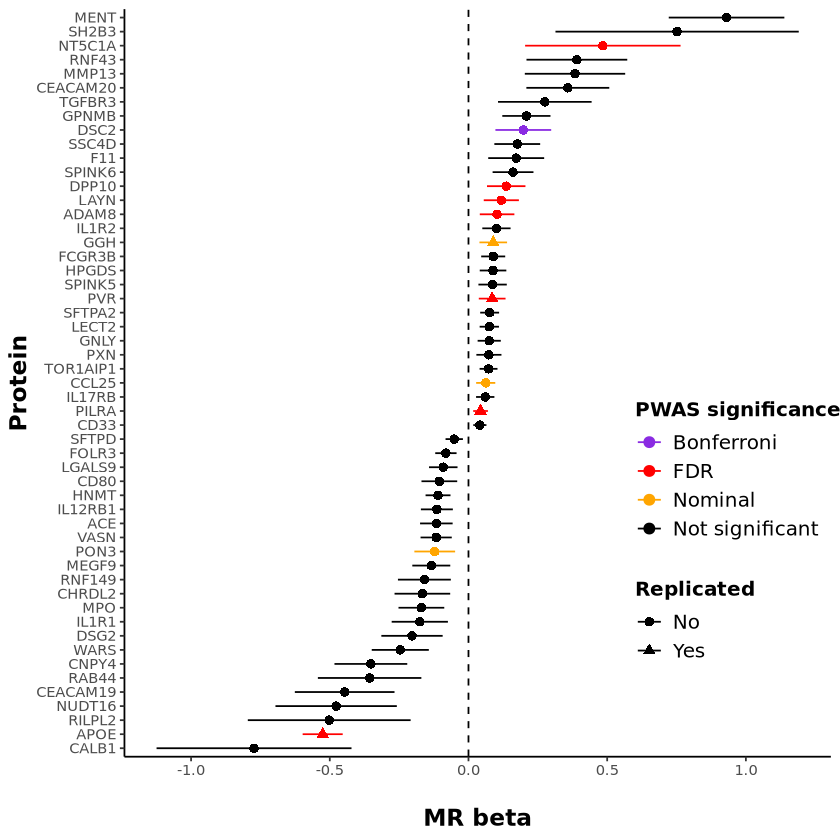

In [28]:
mr_to_plot<-
full_table %>% 
    filter(signif.MRdisc.fdr == 1) %>%
    arrange(b.MRdisc) %>%    
    mutate(`PWAS significance` = case_when(signif.PWAS.bonf == 1 & samedir.PWAS.MRdisc == 1 ~ 'Bonferroni',
                                           signif.PWAS.fdr  == 1 & samedir.PWAS.MRdisc == 1 ~ 'FDR',
                                           signif.PWAS.nom  == 1 & samedir.PWAS.MRdisc == 1 ~ 'Nominal',
                                           TRUE ~ 'Not significant'
                                          ),
           `PWAS significance` = factor(`PWAS significance`, levels = c('Bonferroni', 'FDR', 'Nominal', 'Not significant')),
           Replicated = ifelse(signif.MRrep == 1 & `PWAS significance` != 'Not significant', 'Yes', 'No'),
           PROTEIN = factor(PROTEIN, levels=PROTEIN),
           XMIN = b.MRdisc-1.96*se.MRdisc, 
           XMAX = b.MRdisc+1.96*se.MRdisc
          ) %>%
    select(PROTEIN, b.MRdisc, XMIN, XMAX, `PWAS significance`, Replicated)

ggplot(mr_to_plot, aes(x = b.MRdisc, y = PROTEIN, colour = `PWAS significance`, shape = Replicated)) + 
    geom_pointrange(aes(xmin = XMIN, xmax = XMAX)) + 
    geom_vline(xintercept = 0, lty = "dashed") + 
    theme_classic() +
    scale_color_manual(values=c("blueviolet", "red1", "orange", "black")) + 
    ## legend
    theme(
        legend.title = element_text(size=12, face='bold'),
        legend.text = element_text(size=12),
        legend.position = "inside",
        legend.position.inside = c(0.85,0.3)
    )  + 
    ## reorder shape and color legends
    guides(colour = guide_legend(order = 1),
           shape  = guide_legend(order = 2)
          ) +
    ## axes
    labs(x = "\nMR beta", y = "Protein") +
    theme(axis.title = element_text(size=14, face="bold"))

#ggsave('pQTL_MR_analysis/results/plots/MR_cis_r0.2_ukb_results_f.png', dpi = 500)

#### 7. summary table

In [29]:
prots <- mr_to_plot %>% filter(`PWAS significance`!='Not significant') %>% pull(PROTEIN) %>% as.character
prots

[1] "APOE"   "PON3"   "PILRA"  "CCL25"  "PVR"    "GGH"    "ADAM8"  "LAYN"   "DPP10"  "DSC2"   "NT5C1A"

In [30]:
full_table_sensitivity <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/st14_MRsensitivity.csv')
fuller_table <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/st13_MRmain.csv')

In [31]:
# subset each sensitivity MR
sens_subset <- function(df, mr_method) {
    df_subset <-
    full_table_sensitivity %>% 
        filter(exposure %in% prots & method == mr_method) %>%
        select(-c(starts_with('outcome'), starts_with('nsnp'), 'method')) %>%
        rename_at(vars(!matches("exposure")), ~ paste0(mr_method,'.', .)) %>%
        rename(PROTEIN = exposure) %>%
    return(df_subset)
}

mr_egger <- sens_subset(full_table_sensitivity, mr_method='MR_Egger')
ml <- sens_subset(full_table_sensitivity, mr_method='ML')
wm <- sens_subset(full_table_sensitivity, mr_method='WM')


In [32]:
pleiohet <-
fuller_table %>% 
    filter(PROTEIN %in% prots) %>%
    select(c(PROTEIN, starts_with('egger_intercept.pval'), starts_with('Q_pval')))

In [63]:
main_cols  <- c('PROTEIN', 'PWAS significance','BETA', 'PVALUE', 'FDR', 'nsnp.MRdisc','b.MRdisc', 'se.MRdisc', 'pval.MRdisc','fdr.MRdisc', 'nsnp.MRrep','b.MRrep', 'se.MRrep', 'pval.MRrep')
ph_cols    <- c('egger_intercept.pval.MRdisc', 'egger_intercept.pval.MRrep', 'Q_pval.MRdisc', 'Q_pval.MRrep')
coloc_cols <- c('PP.H4.abf')
drugg_cols <- c('druggability_tier','small_mol_druggable','bio_druggable','adme_gene')

tbl1 <-
full_table %>% 
    filter(PROTEIN %in% prots) %>%
    left_join(., mr_to_plot[,c('PROTEIN','PWAS significance')], by='PROTEIN') %>%
    # add pleio + het 
    left_join(., pleiohet, by='PROTEIN') %>%
    # add sensitivity results
    left_join(., wm, by='PROTEIN') %>%
    left_join(., ml, by='PROTEIN') %>%
    left_join(., mr_egger, by='PROTEIN') %>%
    # add coloc results
    left_join(., coloc_top[,c('protein', 'PP.H4.abf')], by=c('PROTEIN'='protein')) %>%
    select(all_of(main_cols), all_of(ph_cols), starts_with('WM'), starts_with('ML'), starts_with('MR_Egger'), all_of(coloc_cols), all_of(drugg_cols)) %>%
    arrange(druggability_tier, FDR)	

In [64]:
## add nodem MR results
ukb_nodem_IVW_to_merge <-
ukb_nodem_IVW[,c('exposure.MRdisc', 'nsnp.MRdisc', 'b.MRdisc', 'se.MRdisc','pval.MRdisc','fdr.MRdisc')] %>%
    rename_with( ~ paste0(., '.nodem'))
tbl1_plus_nodem <-
tbl1 %>%
    left_join(., y=ukb_nodem_IVW_to_merge, by=c('PROTEIN'='exposure.MRdisc.nodem'))
names(tbl1_plus_nodem)
tbl1_plus_nodem


[1] "PROTEIN"                     "PWAS significance"           "BETA"                        "PVALUE"                      "FDR"                         "nsnp.MRdisc"                
 [7] "b.MRdisc"                    "se.MRdisc"                   "pval.MRdisc"                 "fdr.MRdisc"                  "nsnp.MRrep"                  "b.MRrep"                    
[13] "se.MRrep"                    "pval.MRrep"                  "egger_intercept.pval.MRdisc" "egger_intercept.pval.MRrep"  "Q_pval.MRdisc"               "Q_pval.MRrep"               
[19] "WM.b.MRdisc"                 "WM.se.MRdisc"                "WM.pval.MRdisc"              "WM.b.MRrep"                  "WM.se.MRrep"                 "WM.pval.MRrep"              
[25] "ML.b.MRdisc"                 "ML.se.MRdisc"                "ML.pval.MRdisc"              "ML.b.MRrep"                  "ML.se.MRrep"                 "ML.pval.MRrep"              
[31] "MR_Egger.b.MRdisc"           "MR_Egger.se.MRdisc"          "MR_Egger.pval.MRdisc"        "MR_Egger.b.MRrep"            "MR_Egger.se.MRrep"           "MR_Egger.pval.MRrep"        
[37] "PP.H4.abf"                   "druggability_tier"           "small_mol_druggable"         "bio_druggable"               "adme_gene"                   "nsnp.MRdisc.nodem"          
[43] "b.MRdisc.nodem"              "se.MRdisc.nodem"             "pval.MRdisc.nodem"           "fdr.MRdisc.nodem"

PROTEIN,PWAS significance,BETA,PVALUE,FDR,nsnp.MRdisc,b.MRdisc,se.MRdisc,pval.MRdisc,fdr.MRdisc,⋯,PP.H4.abf,druggability_tier,small_mol_druggable,bio_druggable,adme_gene,nsnp.MRdisc.nodem,b.MRdisc.nodem,se.MRdisc.nodem,pval.MRdisc.nodem,fdr.MRdisc.nodem
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
PON3,Nominal,-0.12388751,1.673183e-02,0.0978981815,21,-0.12161977,0.03747462,1.172896e-03,4.301636e-02,⋯,0.07457857,Tier 1,N,Y,Y,21,-0.169090544,0.04471001,1.556116e-04,1.596060e-02
ADAM8,FDR,0.17520715,9.004042e-05,0.0016956643,22,0.10310541,0.03180558,1.188024e-03,4.301636e-02,⋯,0.20527794,Tier 2,Y,Y,N,22,0.117377311,0.04124385,4.428122e-03,1.040010e-01
GGH,Nominal,0.10031103,3.215986e-02,0.1539206576,36,0.08929917,0.02541272,4.414863e-04,2.245395e-02,⋯,0.51326266,Tier 2,Y,Y,N,36,0.121282783,0.03029851,6.256296e-05,1.086488e-02
PVR,FDR,0.17394154,1.004948e-04,0.0018222301,45,0.08540393,0.02461121,5.202209e-04,2.475338e-02,⋯,0.04012274,Tier 3A,N,Y,N,45,0.089954747,0.02222186,5.165052e-05,1.086488e-02
APOE,FDR,-0.15028511,7.671292e-04,0.0092428346,36,-0.52557330,0.03683868,3.519371e-46,6.116667e-43,⋯,0.99942344,Tier 3A,N,Y,N,36,-0.240985987,0.03674103,5.415421e-11,9.412002e-08
DPP10,FDR,0.13307043,2.477046e-03,0.0231006299,35,0.13604936,0.03534930,1.187392e-04,7.894290e-03,⋯,0.10615305,Tier 3B,Y,N,N,35,0.171646663,0.04216686,4.688158e-05,1.086488e-02
CCL25,Nominal,0.09909649,3.036208e-02,0.1489273816,46,0.06213242,0.01759711,4.142553e-04,2.181745e-02,⋯,0.09577957,Tier 3B,N,Y,N,46,0.055747227,0.02101426,7.982058e-03,1.450441e-01
DSC2,Bonferroni,0.21545186,2.278272e-06,0.0001007618,18,0.19762806,0.05129216,1.166852e-04,7.894290e-03,⋯,0.20052721,NA,NA,NA,NA,18,0.214979088,0.06393555,7.725856e-04,3.822814e-02
NT5C1A,FDR,0.21131857,2.590730e-05,0.0006354909,3,0.48436858,0.14296012,7.036889e-04,3.135926e-02,⋯,0.01905174,NA,NA,NA,NA,3,0.592226618,0.16896728,4.566449e-04,2.871791e-02


In [65]:
# fwrite(tbl1, 'pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/table1.csv')
fwrite(tbl1_plus_nodem, 'pQTL_MR_analysis/results/with_clumped/thres0.2/tables_for_paper/table1_plus_nodem.csv')